In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn import model_selection

production = pd.read_pickle("./processed/production_all_dates_and_variables.pkl")
production2 = pd.read_pickle("./processed/production_full_date_range_pre_impute.pkl")
#print(production.head())
wind_prod = production2['20110325':'20121231230000'][['Wind_KWH','Wind_Speed_AT_WINDFARM']]

In [454]:
#create variables from lagged values
number_lags = 4
df = wind_prod.copy()
for lag in range(1, number_lags + 1):
    df['Wind_KWH_lag_' + str(lag)] = df.Wind_KWH.shift(lag)  
    df['Wind_speed_lag_' + str(lag)] = df.Wind_Speed_AT_WINDFARM.shift(lag)

    
df['windspeed_30day_avg'] = df.Wind_speed_lag_1.rolling('30D').mean()

df['kwh_30day_avg'] = df.Wind_KWH_lag_1.rolling('30D').mean()

df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour

df['power_curve'] = func(df.Wind_Speed_AT_WINDFARM, *popt)
#if you want numpy arrays with no null values: 
df.dropna(inplace=True)#.values #for numpy arrays

# Drop times where wind speed is greater than zero but KWH is zero
# df = df[~((df.Wind_KWH) == 0 & (df.Wind_Speed_AT_WINDFARM > 0))]

#Create train/test(validation) sets
X = df.iloc[:,1:]
y = df.iloc[:,0]
X1, X2 = X[:12200], X[12200:]
y1, y2 = y[:12200], y[12200:]

In [142]:
print('Persistence Model RMSE:', mean_squared_error(y2, y[12199:-1])**.5)

Persistence Model RMSE: 4860.641608559929


In [463]:
#kfold cross validate

seed = 42
k = 5
kfold = model_selection.KFold(n_splits=k, random_state=seed)
model = AdaBoostRegressor(n_estimators=66, 
                          random_state=seed,
                          base_estimator=DecisionTreeRegressor(max_depth=10))#,loss='square')

results = model_selection.cross_val_score(model, X1, y1, cv=kfold, scoring='neg_mean_squared_error')
#predicts = model_selection.cross_val_predict(model,X1,y1,cv=kfold)
#print(((-results)**.5).mean())
print('Cross-Validated Avg RMSE:', np.average(-results, weights=np.repeat(1,k))**.5)
# (-results)**.5

Cross-Validated Avg RMSE: 1997.4200068129933


RMSE train:  566.6703837404383
RMSE TEST:  2178.0127704386437


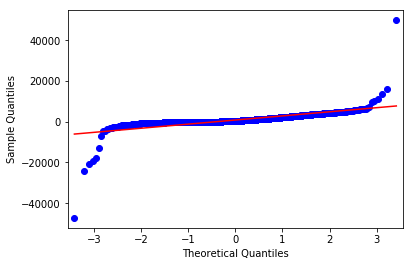

In [465]:
#Validate model
ada = model.fit(X1,y1)

# ada.feature_importances_
print('RMSE train: ', mean_squared_error(y1,ada.predict(X1))**.5)
# y1hat = ada.predict(X1)
# resid = y1-y1hat
# resid.hist();
# sm.qqplot(resid, line='s');
print('RMSE TEST: ', mean_squared_error(y2,ada.predict(X2))**.5)

y2hat = ada.predict(X2)
resid = y2-y2hat

# better_hist(resid,10)
sm.qqplot(resid, line='s');

df_pred = pd.DataFrame(y2)
df_pred['yhat'] = y2hat


In [ ]:
from sklearn.model_selection import GridSearchCV

# Check that base trees can be grid-searched.
# AdaBoost classification
parameters = {'n_estimators': (30, 60, 90, 120, 150, 300),
              'base_estimator__max_depth': (1,3,5,10,15,20,30),
             'learning_rate':(.001,.01,.1,1),
             'loss':('linear','exponential','square')}
clf = GridSearchCV(model, parameters)
clf.fit(X1,y1)



In [480]:
clf.best_estimator_

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=15, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=60,
         random_state=42)

In [440]:
pd.DataFrame( [X2.columns, model.feature_importances_]).T

,0,1
0,Wind_KWH_lag_1,0.171659
1,Wind_speed_lag_1,0.0292542
2,Wind_KWH_lag_2,0.00690288
3,Wind_speed_lag_2,0.00452083
4,Wind_KWH_lag_3,0.00435508
5,Wind_speed_lag_3,0.0039513
6,Wind_KWH_lag_4,0.00426902
7,Wind_speed_lag_4,0.00336891
8,windspeed_30day_avg,0.0104027
9,kwh_30day_avg,0.00997628


In [449]:
#We can see that the predictions faile when the wind speed is high but the the production is low
resid.sort_values().head(10)

Time
2012-12-25 13:00:00   -39176.000000
2012-12-25 12:00:00   -24468.000000
2012-12-31 18:00:00   -21344.000000
2012-11-26 12:00:00   -19456.000000
2012-11-25 08:00:00   -18212.000000
2012-09-28 10:00:00   -12404.666667
2012-09-20 12:00:00    -7028.000000
2012-12-29 20:00:00    -4960.000000
2012-12-25 14:00:00    -4476.000000
2012-12-30 06:00:00    -3347.217391
Name: Wind_KWH, dtype: float64

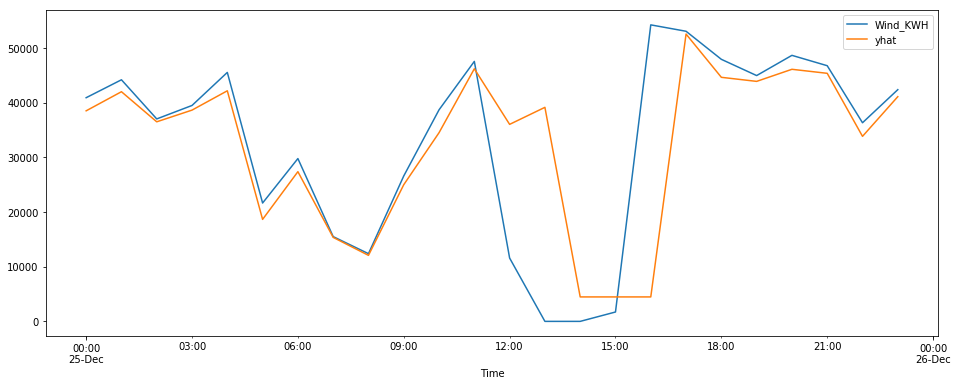

In [448]:
df_pred['20121225':'20121225230000'].plot(figsize=(16,6));

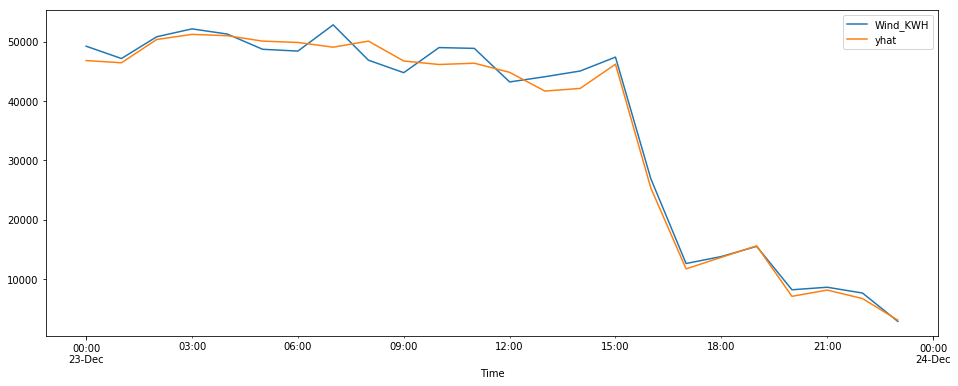

In [453]:
df_pred['20121223':'20121223230000'].plot(figsize=(16,6));

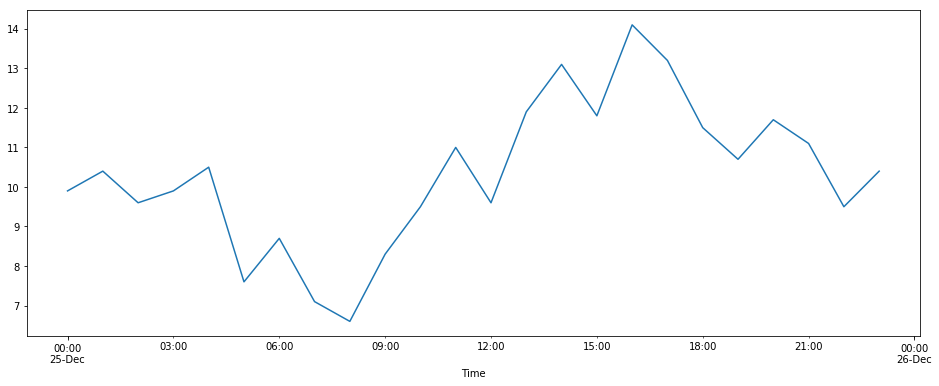

In [443]:
df['20121225':'20121225230000'].Wind_Speed_AT_WINDFARM.plot(figsize=(16,6))

In [307]:
from matplotlib.ticker import FormatStrFormatter
#https://stackoverflow.com/questions/6352740/matplotlib-label-each-bin
def better_hist(data, bins):
    fig, ax = plt.subplots(figsize = (16,6))
    counts, bins, patches = ax.hist(data, facecolor='yellow', edgecolor='gray',bins=bins)

    # Set the ticks to be at the edges of the bins.
    ax.set_xticks(bins)
    # Set the xaxis's tick labels to be formatted with 1 decimal place...
    ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))

    # Change the colors of bars at the edges...
    twentyfifth, seventyfifth = np.percentile(data, [25, 75])
    for patch, rightside, leftside in zip(patches, bins[1:], bins[:-1]):
        if rightside < twentyfifth:
            patch.set_facecolor('green')
        elif leftside > seventyfifth:
            patch.set_facecolor('red')

    # Label the raw counts and the percentages below the x-axis...
    bin_centers = 0.5 * np.diff(bins) + bins[:-1]
    for count, x in zip(counts, bin_centers):
        # Label the raw counts
        ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
            xytext=(0, -18), textcoords='offset points', va='top', ha='center')

        # Label the percentages
        percent = '%0.0f%%' % (100 * float(count) / counts.sum())
        ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
            xytext=(0, -32), textcoords='offset points', va='top', ha='center')


    # Give ourselves some more room at the bottom of the plot
    plt.subplots_adjust(bottom=0.15)
    plt.show();

[7.64217636e+01 1.42634064e-03 2.58067998e-01 6.30198207e-01
 1.58224359e-01]


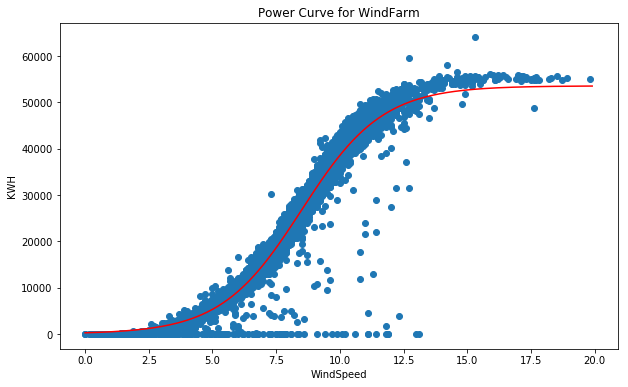

In [398]:
#Fit a curve to the above data
from scipy.optimize import curve_fit

#This function fits the powercurve
def func(x, a, b, c, d, e):
    return a / (b + c*np.exp(-d*x + e))
#Define the data to be fit with some noise:

popt, pcov = curve_fit(func, df.Wind_Speed_AT_WINDFARM, df.Wind_KWH)
print(popt)
plt.figure(figsize=(10,6))
#plt.scatter(df.Wind_Speed_AT_WINDFARM,func(df.Wind_Speed_AT_WINDFARM, *popt))
plt.scatter(df.Wind_Speed_AT_WINDFARM,df.Wind_KWH)
plt.plot(np.arange(0,20,.1),func(np.arange(0,20,.1),*popt),color='red')
# plt.plot(np.arange(0,20,.1),func(np.arange(0,20,.1),*popt)+7000,color='red')
# plt.plot(np.arange(0,20,.1),func(np.arange(0,20,.1),*popt)-7000,color='red')
plt.xlabel('WindSpeed')
plt.ylabel('KWH')
plt.title('Power Curve for WindFarm');

In [441]:
#If we used this power curve as our function, how would the model perform?
print('Power Curve Model RMSE: ', 
      mean_squared_error(df.Wind_KWH[12200:],func(df.Wind_Speed_AT_WINDFARM, *popt)[12200:])**.5)

Power Curve Model RMSE:  2268.636533724044


In [ ]:
#Next step, plug the power curve into the AdaBoost model to see how that performs.